In [446]:
from IPython.display import HTML



#### Przygotowanie modeli i krzywych CP.

Zmienna objaśniana (wydatki na opiekę zdrowotną) została przekształcona z wykorzystaniem logarytmu o podstawie 3 (blisko logarytmu naturalnego, ale łatwiejsze w interpretacji). W związku z tym interpretacja jest następująca - jeśli zmiana jakiegoś wejścia spowodowała wzrost predykcji o $n$ tzn. że wydatki na OZ wzrosły o $3^n$.

In [402]:
import pandas as pd
import numpy as np
import os

import shap
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, \
roc_auc_score, precision_recall_curve, confusion_matrix, r2_score, mean_absolute_error, \
mean_squared_error
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [443]:
pd.options.display.max_columns = 200

In [299]:
!dir data

 Volume in drive C is Windows
 Volume Serial Number is 5441-C8EF

 Directory of C:\Users\bialekj\Documents\Moje\Doktorat wdrozeniowy\wyklady\XAI\pd4\data

15.04.2020  14:46    <DIR>          .
15.04.2020  14:46    <DIR>          ..
22.03.2020  18:25         2˙452˙351 MEPS_data_preprocessed.csv
               1 File(s)      2˙452˙351 bytes
               2 Dir(s)  48˙090˙234˙880 bytes free


In [300]:
data_dir = 'data'
df = pd.read_csv(os.path.join(data_dir, 'MEPS_data_preprocessed.csv'))
df.reset_index(drop=True, inplace=True)
df_raw = df.copy()

In [309]:
df = df.drop('PANEL', axis=1)

In [310]:
y = df.pop('HEALTHEXP')

In [311]:
y_loge = np.log(y)
y_loge[y==0] = 0
y_log3 = y_loge / np.log(3) 
y_log3 = np.asarray(y_log3)
y = np.asarray(y)

c:\users\bialekj\appdata\local\programs\python\python36\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



In [312]:
categorical_features = ['REGION','MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15','RACE3','GENDER']

numerical_features= [feat for feat in df.columns if feat not in categorical_features]

In [313]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

regressor = GradientBoostingRegressor(n_estimators=300, random_state=42)

mdl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])

In [314]:
X_train, X_test, y_train, y_test = train_test_split(df, y_log3, test_size=0.2, random_state=42)
mdl.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['AGE31X', 'PCS42', 'MCS42',
                                                   'K6SUM42', 'INCOME_M',
                                    

In [315]:
y_pred = mdl.predict(X_test)
r2_score(y_test,y_pred)

0.3756526032677451

In [316]:
model1 = mdl

In [317]:
regressor = LinearRegression()
mdl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])

In [318]:
mdl.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['AGE31X', 'PCS42', 'MCS42',
                                                   'K6SUM42', 'INCOME_M',
                                    

In [319]:
y_pred = mdl.predict(X_test)
r2_score(y_test,y_pred)

0.3517170921229019

In [320]:
model2 = mdl

#### Model Gradient Boosting Regressor

In [321]:
import dalex as dx 

In [322]:
model1

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['AGE31X', 'PCS42', 'MCS42',
                                                   'K6SUM42', 'INCOME_M',
                                    

In [323]:
exp = dx.Explainer(model1, df, y_log3, label = "GBR")

Preparation of a new explainer is initiated

  -> label             : GBR
  -> data              : 18350 rows 44 cols
  -> target variable   : 18350 values
  -> predict function  : <function yhat_default at 0x000001D35D0FAD90> will be used
  -> predicted values  : min = -0.5263935188373152, mean = 5.712206973487643, max = 10.336867422601017
  -> residual function : difference between y and yhat
  -> residuals         : min = -9.516194862227534, mean = 0.003236789297550328, max = 7.676258789484571
  -> model_info        : package sklearn

A new explainer has been created!


In [435]:
idx = 8
x_example = df.iloc[idx:idx+1]

In [437]:
exp.predict(x_example)

array([7.46312436])

In [438]:
cp = exp.predict_profile(x_example)

Calculating ceteris paribus!: 100%|████████████████████████████████████████████████████| 44/44 [00:00<00:00, 60.32it/s]


In [439]:
cp.plot(variables=["INCOME_M"])

In [444]:
x_example

,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,MNHLTH31,HIBPDX,CHDDX,ANGIDX,MIDX,OHRTDX,STRKDX,EMPHDX,CHBRON31,CHOLDX,CANCERDX,DIABDX,JTPAIN31,ARTHDX,ARTHTYPE,ASTHDX,ADHDADDX,PREGNT31,WLKLIM31,ACTLIM31,SOCLIM31,COGLIM31,DFHEAR42,DFSEE42,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,PERSONWT
8,1,35,1.0,0.0,1,16,-1,2,2,2,3,2,2,2,2,1,2,2,2,1,2,2,2,2,-1,2,-1,2,2,2,2,2,2,2,2,54.3,43.43,4,1,1,5,1,56052.0,17508.950341


In [429]:
idx = 90
x_example2 = df.iloc[idx:idx+1]
exp.predict(x_example2)
cp2 = exp.predict_profile(x_example2)
cp2.plot(variable_type="numerical", variables=["INCOME_M"])

Calculating ceteris paribus!: 100%|████████████████████████████████████████████████████| 44/44 [00:00<00:00, 61.40it/s]


In [445]:
x_example2

,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,MNHLTH31,HIBPDX,CHDDX,ANGIDX,MIDX,OHRTDX,STRKDX,EMPHDX,CHBRON31,CHOLDX,CANCERDX,DIABDX,JTPAIN31,ARTHDX,ARTHTYPE,ASTHDX,ADHDADDX,PREGNT31,WLKLIM31,ACTLIM31,SOCLIM31,COGLIM31,DFHEAR42,DFSEE42,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,PERSONWT
90,4,83,0.0,0.0,2,16,-1,4,1,4,3,2,2,2,2,2,2,2,2,1,1,2,1,1,3,2,-1,-1,2,2,2,2,1,2,-1,-1.0,-1.0,-1,-1,4,4,1,9000.0,0.0


W pierwszym przypadku, dla wybranej obserwacji, zwiększenie zarobków przy zachowaniu pozostałych wejść niezmienionych powoduje wzrost wydatków na opiekę zdrowotną. Obserwacja ta dotyczy pacjenta w wieku 35 lat. Można przypuszczać, że w takim wieku każdy ma jakieś schorzenia - mniejsze lub większe. Ci mniej zarabiający zajmują się tymi, które najbardziej im dolegają. Ci, którzy zarabiają więcej, leczą się bardziej kompleksowo - wydając przy tym więcej pieniędzy. Dodatkowo, lepiej zarabiający zwykle prowadzą bardziej intensywny tryb życia - krócej śpią, mają więcej stresów, są narażeni na kontuzje ze względu na wykonywanie prac niebezpiecznych itd. To przekłada się na częstsze i bardziej kosztowne wizyty u specjalistów. W przypadku ankietowanego z drugiej obserwacji, zwiększenie wejścia odpowiadającego za zarobki przy pozostałych wejściach stalych powoduje niewielki spadek wydatków na OZ. Ankietowany ma 83 lata, być może w tym wieku ta zmienna nie jest aż tak istotna.

(0, 250)

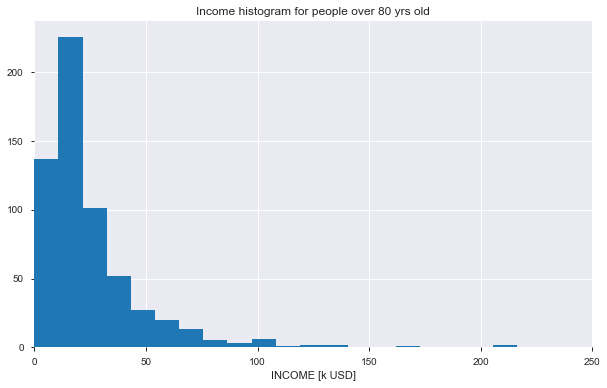

In [423]:
plt.figure(figsize=(10,6))
income_old = df[df['AGE31X']>80]['INCOME_M']/1000
income_old.hist(bins=20)

plt.title('Income histogram for people over 80 yrs old')
plt.xlabel('INCOME [k USD]');
plt.xlim(0,250)


(0, 250)

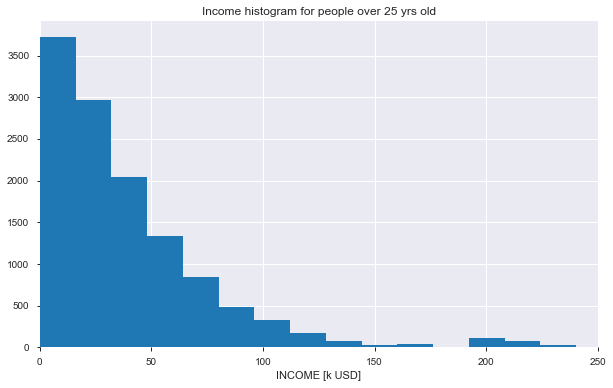

In [422]:
plt.figure(figsize=(10,6))
income_all = df[df['AGE31X']>25]['INCOME_M']/1000
income_all.hist(bins=20)

plt.title('Income histogram for people over 25 yrs old')
plt.xlabel('INCOME [k USD]');
plt.xlim(0,250)

#### Model liniowy

In [333]:
model2

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['AGE31X', 'PCS42', 'MCS42',
                                                   'K6SUM42', 'INCOME_M',
                                    

In [334]:
exp2 = dx.Explainer(model2, df, y_log3, label = "GBR")

Preparation of a new explainer is initiated

  -> label             : GBR
  -> data              : 18350 rows 44 cols
  -> target variable   : 18350 values
  -> predict function  : <function yhat_default at 0x000001D35D0FAD90> will be used
  -> predicted values  : min = 0.1841006146568871, mean = 5.714977408746465, max = 12.242035685091384
  -> residual function : difference between y and yhat
  -> residuals         : min = -9.674257016665672, mean = 0.0004663540387282032, max = 7.242568473035798
  -> model_info        : package sklearn

A new explainer has been created!


In [335]:
numerical_features

['AGE31X', 'PCS42', 'MCS42', 'K6SUM42', 'INCOME_M', 'PERSONWT']

In [338]:
y_pred_test = model2.predict(X_test)

In [348]:
len(X_test), len(y_test), len(y_pred_test)

(3670, 3670, 3670)

In [394]:
X_test = X_test.reset_index(drop=True)

In [395]:
results = X_test.copy()

In [396]:
results['y']= y_test
results['y_pred'] = y_pred_test
results['delt_y'] =abs(y_test-y_pred_test)

In [397]:
results.sort_values(by=['delt_y'])

,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,...,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,PERSONWT,y,y_pred,delt_y
2727,2,63,1.0,0.0,1,13,-1,4,2,3,...,5,0,4,4,2,7800.0,8126.793162,7.927997,7.929354,0.001357
2259,1,11,1.0,0.0,6,1,-1,3,3,1,...,-1,-1,-1,4,1,0.0,16219.559433,5.446814,5.444735,0.002078
103,4,76,1.0,1.0,3,13,-1,4,2,3,...,0,0,4,5,2,26281.0,6156.641044,6.650691,6.648507,0.002184
3389,3,0,1.0,1.0,6,-1,-1,3,3,1,...,-1,-1,-1,1,2,0.0,3541.050238,4.706377,4.703991,0.002386
671,1,34,0.0,0.0,5,14,-1,2,2,1,...,2,1,1,2,1,14200.0,8187.128331,4.319023,4.322092,0.003069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,4,26,1.0,0.0,5,13,-1,2,2,1,...,0,0,1,4,1,24000.0,10642.910037,0.000000,7.211754,7.211754
2697,2,54,0.0,0.0,1,13,-1,2,1,3,...,4,2,1,4,1,56454.0,8539.518943,0.000000,7.337314,7.337314
118,3,36,1.0,0.0,1,13,-1,2,2,2,...,0,0,4,1,1,0.0,8419.929190,0.000000,7.367773,7.367773
2361,3,83,1.0,0.0,2,13,-1,4,2,3,...,6,2,4,3,1,19740.0,16552.202120,0.000000,9.293663,9.293663


In [400]:
idx = 1287
x_example2 = X_test.iloc[idx:idx+1]
exp2.predict(x_example2)
cp2 = exp2.predict_profile(x_example2)
cp2.plot(variables=numerical_features)

Calculating ceteris paribus!: 100%|████████████████████████████████████████████████████| 44/44 [00:00<00:00, 64.16it/s]


In [403]:
idx = 15
x_example2 = X_test.iloc[idx:idx+1]
exp2.predict(x_example2)
cp2 = exp2.predict_profile(x_example2)
cp2.plot(variables=numerical_features)


Calculating ceteris paribus!: 100%|████████████████████████████████████████████████████| 44/44 [00:00<00:00, 61.99it/s]


Dla modelu liniowego krzywe Ceteris Paribus są takie same jeśli chodzi o współczynnik nachylenia, róznią się o stałą (która z kolei wynika z wartości pozostałych zmiennych dla danej obserwacji). Próżno więc szukać obserwacji, dla których krzywe CP mają odmienny charakter jakościowy. Spodziewałem sie tego, ale chciałem to zobaczyć na własne oczy, żeby potwierdzić rozumienie i dlatego wybrałem model liniowy.